# Pancreatic Cancer Detection Notebook

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Loading and Preprocessing 

    - Note: we should do some data visualizations --> heatmaps? histograms of label distributions for proof
        - of good splits. mutual information??? (need to better understand if its useful)


In [19]:
# Loading urinary biomarker dataset
urinary_df = pd.read_csv('urinaryBiomarkerData.csv')
urinary_df = urinary_df.drop(columns=['sample_id','patient_cohort','sample_origin','age','sex','stage','benign_sample_diagnosis','plasma_CA19_9','REG1A'])
columnOrder = ["LYVE1", "TFF1", "REG1B", "creatinine", "diagnosis"]
# Reorder the columns in the DataFrame
urinary_df = urinary_df[columnOrder]
urinary_df.rename(columns={'diagnosis': 'Diagnosis', "creatinine": "Creatinine"}, inplace=True)

print(urinary_df)

        LYVE1         TFF1       REG1B  Creatinine  Diagnosis
0    0.893219   654.282174   52.948840     1.83222          1
1    2.037585   209.488250   94.467030     0.97266          1
2    0.145589   461.141000  102.366000     0.78039          1
3    0.002805   142.950000   60.579000     0.70122          1
4    0.000860    41.088000   65.540000     0.21489          1
..        ...          ...         ...         ...        ...
585  7.058209   525.178000  156.241000     0.52026          3
586  8.341207   245.947000   16.915000     0.85956          3
587  7.674707   537.286000  289.701000     1.36851          3
588  8.206777   722.523000  205.930000     1.33458          3
589  8.200958  2021.321078  411.938275     1.50423          3

[590 rows x 5 columns]


In [20]:
# Preprocessing urinary biomarker dataset
# NOTE: There are no negative or Null/NaN values in the dataset
    # So, no need to remove samples or impute the data
    # Only need to scale the appropriate data columns


# Relabel non-cancer to be 0, cancer to be 1
urinary_df['Diagnosis'] = urinary_df['Diagnosis'].replace(2, 0)
urinary_df['Diagnosis'] = urinary_df['Diagnosis'].replace(1, 0)
urinary_df['Diagnosis'] = urinary_df['Diagnosis'].replace(3, 1)


scaler = StandardScaler()
val_cols = urinary_df.loc[:, ~urinary_df.columns.isin(['Diagnosis'])]
urinary_df[val_cols.columns] = scaler.fit_transform(val_cols)

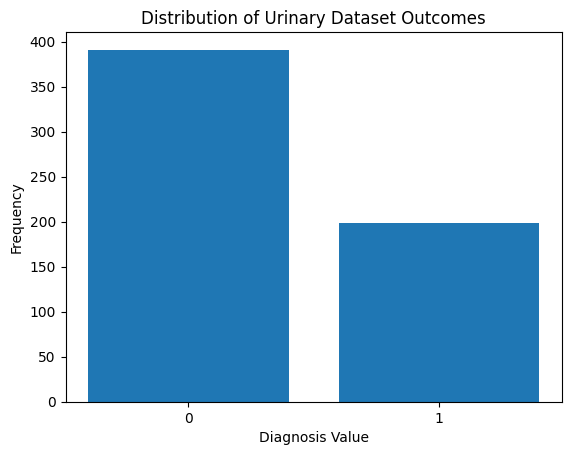

In [21]:
# Examine Distribution of urinary dataset
values = urinary_df['Diagnosis'].value_counts()
plt.bar(values.index, values.values)
plt.xticks([0,1])
plt.xlabel("Diagnosis Value")
plt.ylabel("Frequency")
plt.title("Distribution of Urinary Dataset Outcomes")
plt.show()

In [22]:
# Split data into training/validation and test (80/20)

train_urinary_data, test_urinary_data = train_test_split(urinary_df, test_size=0.2, random_state=4, shuffle=True)

print("train length is " + str(len(train_urinary_data)) + "... test length is " + str(len(test_urinary_data)))
print("train_urinary_data: \n", train_urinary_data)
print("test_urinary_data: \n", test_urinary_data)

train length is 472... test length is 118
train_urinary_data: 
         LYVE1      TFF1     REG1B  Creatinine  Diagnosis
569  1.729341  2.236736  0.169357    2.451043          1
467  0.896179  0.074365 -0.180192   -0.046599          1
63  -0.886494 -0.574698 -0.503176   -1.144853          0
507  0.791824  0.162043 -0.385763    1.405930          1
212  0.023265 -0.478069 -0.346764   -0.353048          0
..        ...       ...       ...         ...        ...
456  0.744419  0.296983  1.504107   -0.985429          1
360  0.280443 -0.286411 -0.396328   -0.613440          0
439  1.707320  2.481479  1.339816   -0.294592          1
174 -0.891536 -0.568532 -0.396628   -1.215708          0
122 -0.889930 -0.479479 -0.425504    0.945372          0

[472 rows x 5 columns]
test_urinary_data: 
         LYVE1      TFF1     REG1B  Creatinine  Diagnosis
424 -0.365876  0.137482  0.403048    0.219107          1
583  0.786063  1.334465  4.274874   -0.294592          1
210  0.522988  2.660132  3.021212   

# Model Creation
5 classifiers: Random Forest Classifier. XGBoost, Support Vector Machine, Gaussian Naive Bayes, and K Neighbors Classifier


In [23]:
# ! pip3 install xgboost

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [25]:
# NOTE: add/remove/adjust hyperparameters as you see fit
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.01)
svm = SVC(C=1, kernel="rbf", random_state=42)
gnb = GaussianNB()
knn = KNeighborsClassifier()

# Training and Validation

In [26]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

rf_scores = []
xgb_scores = []
svm_scores = []
gnb_scores = []
knn_scores = []

X = train_urinary_data
kf = KFold(n_splits=10)

for train_index, val_index in kf.split(X): #10 folds
    # set up training data
    train_chunk = X.iloc[train_index]
    y_train = train_chunk['Diagnosis']
    X_train = train_chunk.drop(columns=['Diagnosis'])

    # set up validation data
    val_chunk = X.iloc[val_index]
    y_val = val_chunk['Diagnosis']
    X_val = val_chunk.drop(columns=['Diagnosis'])

    # Random Forest
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_val)
    rf_score = accuracy_score(y_val, rf_pred)
    rf_scores.append(rf_score)

    # XGBoost
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_val)
    xgb_score = accuracy_score(y_val, xgb_pred)
    xgb_scores.append(xgb_score)

    # SVM
    svm.fit(X_train, y_train)
    svm_pred = svm.predict(X_val)
    svm_score = accuracy_score(y_val, svm_pred)
    svm_scores.append(svm_score)

    # Gaussian Naive Bayes
    gnb.fit(X_train, y_train)
    gnb_pred = gnb.predict(X_val)
    gnb_score = accuracy_score(y_val, gnb_pred)
    gnb_scores.append(gnb_score)

    # KNearestNeighbors
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_val)
    knn_score = accuracy_score(y_val, knn_pred)
    knn_scores.append(knn_score)

print("RF training accuracies: ", rf_scores)
print("RF mean: ", np.mean(rf_scores))
print("RF standard dev: ", np.std(rf_scores), "\n")

print("XGB training accuracies: ", xgb_scores)
print("XGB mean: ", np.mean(xgb_scores))
print("XGB standard dev: ", np.std(xgb_scores), "\n")

print("SVM training accuracies: ", svm_scores)
print("SVM mean: ", np.mean(svm_scores))
print("SVM standard dev: ", np.std(svm_scores), "\n")

print("GNB training accuracies: ", gnb_scores)
print("GNB mean: ", np.mean(gnb_scores))
print("GNB standard dev: ", np.std(gnb_scores), "\n")

print("KNN training accuracies: ", knn_scores)
print("KNN mean: ", np.mean(knn_scores))
print("KNN standard dev: ", np.std(knn_scores), "\n")

RF training accuracies:  [0.7916666666666666, 0.9166666666666666, 0.8297872340425532, 0.7021276595744681, 0.7872340425531915, 0.7659574468085106, 0.8085106382978723, 0.8085106382978723, 0.851063829787234, 0.7872340425531915]
RF mean:  0.8048758865248228
RF standard dev:  0.05305308530300568 

XGB training accuracies:  [0.7291666666666666, 0.875, 0.8085106382978723, 0.6382978723404256, 0.851063829787234, 0.7659574468085106, 0.8297872340425532, 0.8085106382978723, 0.8085106382978723, 0.8085106382978723]
XGB mean:  0.792331560283688
XGB standard dev:  0.06414460447544047 

SVM training accuracies:  [0.7708333333333334, 0.8958333333333334, 0.9148936170212766, 0.6382978723404256, 0.8085106382978723, 0.8085106382978723, 0.7872340425531915, 0.8085106382978723, 0.8297872340425532, 0.851063829787234]
SVM mean:  0.8113475177304965
SVM standard dev:  0.07209038669915623 

GNB training accuracies:  [0.7708333333333334, 0.875, 0.8297872340425532, 0.6170212765957447, 0.6808510638297872, 0.7446808510

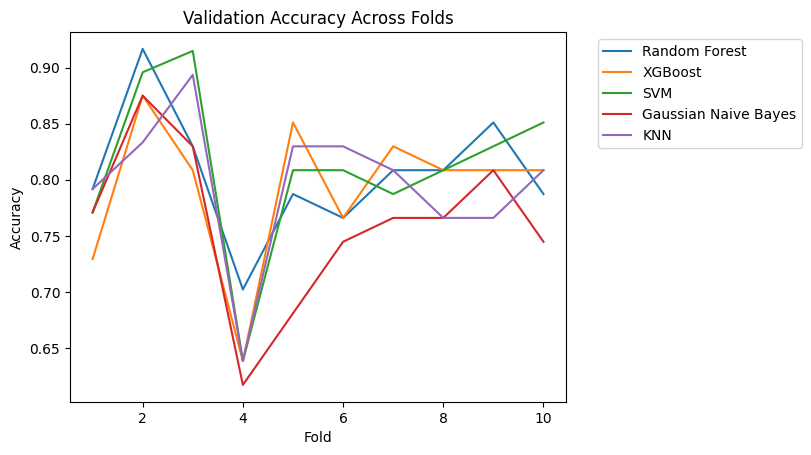

In [51]:
#Plot Validation Accuracy
foldsList = [i for i in range(1, 11)]

plt.plot(foldsList, rf_scores, label="Random Forest")
plt.plot(foldsList, xgb_scores, label="XGBoost")
plt.plot(foldsList, svm_scores, label="SVM")
plt.plot(foldsList, gnb_scores, label="Gaussian Naive Bayes")
plt.plot(foldsList, knn_scores, label="KNN")

plt.title("Validation Accuracy Across Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# Testing Models

In [28]:
# set up test data
X_test = test_urinary_data.drop(columns=['Diagnosis'])
y_test = test_urinary_data['Diagnosis']

# Random Forest
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("RF test accuracy: ", rf_acc)

# XGBoost
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print("XGB test accuracy: ", xgb_acc)

# SVM
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print("SVM test accuracy: ", svm_acc)

# Gaussian Naive Bayes
gnb_pred = gnb.predict(X_test)
gnb_acc = accuracy_score(y_test, gnb_pred)
print("GNB test accuracy: ", gnb_acc)

# KNearestNeighbors
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)
print("KNN test accuracy: ", knn_acc)

RF test accuracy:  0.7796610169491526
XGB test accuracy:  0.7711864406779662
SVM test accuracy:  0.7966101694915254
GNB test accuracy:  0.7711864406779662
KNN test accuracy:  0.8050847457627118


In [29]:
# F1 scores for testing on urinary dataset
from sklearn.metrics import f1_score

rf_f1 = f1_score(y_test, rf_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
svm_f1 = f1_score(y_test, svm_pred)
gnb_f1 = f1_score(y_test, gnb_pred)
knn_f1 = f1_score(y_test, knn_pred)

print("RF F1 score: ", rf_f1)
print("XGB F1 score: ", xgb_f1)
print("SVM F1 score: ", svm_f1)
print("GNB F1 score: ", gnb_f1)
print("KNN F1 score: ", knn_f1)

RF F1 score:  0.6829268292682926
XGB F1 score:  0.64
SVM F1 score:  0.7
GNB F1 score:  0.5846153846153846
KNN F1 score:  0.7160493827160495


# ------------- NCBI DATA WORK --------

### Normal pancreas RNA-seq data

In [30]:
# Normal pancreas dataset 1
markers = ['LYVE1','TFF1','REG1B','GPX1']

rawPancNormData1 = pd.read_csv("pancreaticNormalSeqData/GSE205163_znf808_ko_raw_counts_S0-S4.tsv",  sep='\t')
filtRawPancNormData1 = rawPancNormData1[rawPancNormData1['Gene'].str.endswith(('LYVE1','REG1B','TFF1','GPX1'))]
filtRawPancNormData1 = filtRawPancNormData1.set_index('Gene')
filtRawPancNormData1 = filtRawPancNormData1.transpose()
filtRawPancNormData1 = filtRawPancNormData1.reset_index(drop=True)
filtRawPancNormData1.columns = markers
filtRawPancNormData1.rename(columns={"GPX1": "Creatinine"}, inplace=True)
#print(filtRawPancNormData1)

filtRawPancNormData1Scaler = StandardScaler()
scaledRawPancNormData1 = filtRawPancNormData1Scaler.fit_transform(filtRawPancNormData1)
scaledRawPancNormData1 = pd.DataFrame(scaledRawPancNormData1, columns=filtRawPancNormData1.columns)
scaledRawPancNormData1["Diagnosis"] = 0

print(scaledRawPancNormData1)


       LYVE1      TFF1     REG1B  Creatinine  Diagnosis
0   0.603023 -1.177057 -0.312348    0.761342          0
1  -0.527645 -1.177057 -0.312348    1.162652          0
2  -0.527645  2.075338 -0.312348    0.069336          0
3  -0.527645  0.449140  2.030259    0.732340          0
4  -0.527645 -0.247802 -0.312348   -0.348836          0
5  -0.527645  1.610710 -0.312348   -0.999700          0
6  -0.527645 -0.944743 -0.312348   -0.092537          0
7  -0.527645 -1.177057 -0.312348   -0.287459          0
8  -0.527645  1.378396 -0.312348   -0.514756          0
9  -0.527645 -0.015488 -0.312348   -1.301863          0
10  0.603023 -1.177057 -0.312348    1.524843          0
11  0.603023 -1.177057 -0.312348    0.634542          0
12 -0.527645  0.216826 -0.312348    0.202206          0
13 -0.527645  0.681454  4.372865   -0.212593          0
14  1.733690 -0.247802 -0.312348   -0.626718          0
15 -0.527645  1.378396 -0.312348   -0.043975          0
16 -0.527645 -0.247802 -0.312348   -0.173474    

In [31]:
# Normal pancreas dataset 2
rawPancNormData2 = pd.read_csv("pancreaticNormalSeqData/GSE216854_normalized_counts.txt", sep='\t')
filtRawPancNormData2 = rawPancNormData2[rawPancNormData2['gene'].isin(markers)]
filtRawPancNormData2 = filtRawPancNormData2.set_index('gene')
filtRawPancNormData2 = filtRawPancNormData2.transpose()
filtRawPancNormData2 = filtRawPancNormData2.reset_index(drop=True)
filtRawPancNormData2.rename(columns={"GPX1": "Creatinine"}, inplace=True)

# Reorder the columns in the DataFrame
columnOrder = ["LYVE1", "TFF1", "REG1B", "Creatinine"]
filtRawPancNormData2 = filtRawPancNormData2[columnOrder]
#print(filtRawPancNormData2)

filtRawPancNormData1Scaler2 = StandardScaler()
scaledRawPancNormData2 = filtRawPancNormData1Scaler2.fit_transform(filtRawPancNormData2)
scaledRawPancNormData2 = pd.DataFrame(scaledRawPancNormData2, columns=filtRawPancNormData2.columns)
scaledRawPancNormData2["Diagnosis"] = 0
print(scaledRawPancNormData2)


gene     LYVE1      TFF1     REG1B  Creatinine  Diagnosis
0     1.212172 -0.414569 -0.222204   -0.728370          0
1    -0.601634  2.289087 -0.222204   -0.762900          0
2    -0.601634  1.401099 -0.222204   -0.905547          0
3     1.992331  1.282733 -0.222204   -1.322138          0
4    -0.601634  2.063121 -0.222204   -1.445888          0
5     0.924537  4.151805 -0.222204   -1.653851          0
6     2.169985  0.836218 -0.222204   -1.450046          0
7    -0.601634  1.137392 -0.222204   -1.582078          0
8     0.805753 -0.310619 -0.222204   -1.670140          0
9    -0.601634 -0.602931 -0.222204   -0.294469          0
10   -0.601634 -0.391989 -0.222204   -0.241374          0
11   -0.601634 -0.350597 -0.222204   -0.183727          0
12   -0.601634 -0.602931 -0.222204    0.497534          0
13   -0.601634 -0.602931 -0.222204    0.060106          0
14   -0.601634 -0.602931 -0.222204    0.028425          0
15    2.292054 -0.001918  3.931583    2.360045          0
16   -0.601634

In [32]:
# Normal pancreas dataset 3
rawPancNormData3 = pd.read_csv("pancreaticNormalSeqData/GSE228662_RNA_raw_read_counts.tsv", sep='\t')
filtRawPancNormData3 = rawPancNormData3[rawPancNormData3['symbol'].isin(markers)]
filtRawPancNormData3 = filtRawPancNormData3.set_index('symbol')
filtRawPancNormData3 = filtRawPancNormData3.drop(columns=['chrom','start','end','gene'])
filtRawPancNormData3 = filtRawPancNormData3.transpose()
filtRawPancNormData3 = filtRawPancNormData3.reset_index(drop=True)

filtRawPancNormData3.rename(columns={"GPX1": "Creatinine"}, inplace=True)
columnOrder = ["LYVE1", "TFF1", "REG1B", "Creatinine"]

# Reorder the columns in the DataFrame
filtRawPancNormData3 = filtRawPancNormData3[columnOrder]
#print(filtRawPancNormData3)

filtRawPancNormData1Scaler3 = StandardScaler()
scaledRawPancNormData3 = filtRawPancNormData1Scaler3.fit_transform(filtRawPancNormData3)
scaledRawPancNormData3 = pd.DataFrame(scaledRawPancNormData3, columns=filtRawPancNormData3.columns)
scaledRawPancNormData3["Diagnosis"] = 0
print(scaledRawPancNormData3)


symbol     LYVE1      TFF1     REG1B  Creatinine  Diagnosis
0      -0.577293  0.366796 -0.160845    1.125271          0
1      -0.577293  1.197512 -0.160845    1.873122          0
2      -0.032524  0.482173 -0.160845    0.631829          0
3      -0.032524  0.020665 -0.160845    0.577313          0
4      -0.577293  0.424485 -0.160845    0.578711          0
..           ...       ...       ...         ...        ...
62     -0.577293 -0.521608 -0.160845   -0.412366          0
63      0.512246 -0.694674 -0.160845    0.041936          0
64     -0.577293 -0.821589 -0.160845    0.219463          0
65     -0.032524 -0.683136 -0.160845   -0.243226          0
66     -0.577293 -0.729287 -0.160845    0.075484          0

[67 rows x 5 columns]


In [33]:
# Concatenate all 3 normal pancreas datasets
allPancNormData = pd.concat([scaledRawPancNormData1, scaledRawPancNormData2, scaledRawPancNormData3], sort=False)
print(allPancNormData)

# NOTE: allPancNormData already has no zeros or NaN/Null, does not need imputing or more processing

       LYVE1      TFF1     REG1B  Creatinine  Diagnosis
0   0.603023 -1.177057 -0.312348    0.761342          0
1  -0.527645 -1.177057 -0.312348    1.162652          0
2  -0.527645  2.075338 -0.312348    0.069336          0
3  -0.527645  0.449140  2.030259    0.732340          0
4  -0.527645 -0.247802 -0.312348   -0.348836          0
..       ...       ...       ...         ...        ...
62 -0.577293 -0.521608 -0.160845   -0.412366          0
63  0.512246 -0.694674 -0.160845    0.041936          0
64 -0.577293 -0.821589 -0.160845    0.219463          0
65 -0.032524 -0.683136 -0.160845   -0.243226          0
66 -0.577293 -0.729287 -0.160845    0.075484          0

[139 rows x 5 columns]


### Pancreatic cancer RNA-seq data

In [34]:
import warnings
warnings.simplefilter("ignore")

rawPancCancData1 = pd.read_csv("pancreaticCancerSeqData/GSE232860_allsamples.deseq.normalized.counts.csv")
rawPancCancData2 = pd.read_excel("pancreaticCancerSeqData/GSE245306_FKPM.xlsx")

rawPancCancData3 = pd.read_csv("pancreaticCancerSeqData/tumor.counts.sub.tsv", sep='\t')
rawPancCancData3 = rawPancCancData3.reset_index()


In [35]:
#Only has Reg1
rowsToKeep = ["Gpx1", "Lyve1", "Reg1", "Tff1"]
rawPancCancData1.rename(columns={'Unnamed: 0': 'GeneNames'}, inplace=True)
#print(rawPancCancData1.shape)

filtRawPancCancData1 = rawPancCancData1[rawPancCancData1['GeneNames'].isin(rowsToKeep)]
filtRawPancCancData1 = filtRawPancCancData1.transpose()
filtRawPancCancData1.reset_index(inplace=True, drop=True)
filtRawPancCancData1.columns = filtRawPancCancData1.iloc[0]
filtRawPancCancData1 = filtRawPancCancData1[1:]

filtRawPancCancData1.rename(columns={'Reg1': 'REG1B', "Gpx1": "Creatinine", "Tff1": "TFF1", "Lyve1": "LYVE1"}, inplace=True)
columnOrder = ["LYVE1", "TFF1", "REG1B", "Creatinine"]

# Reorder the columns in the DataFrame
filtRawPancCancData1 = filtRawPancCancData1[columnOrder]

# Impute missing values in each column if needed
filtRawPancCancData1 = filtRawPancCancData1.fillna(filtRawPancCancData1.median())
#print(filtRawPancCancData1)

filtRawPancCancData1Scaler = StandardScaler()
scaledRawPancCancData1 = filtRawPancCancData1Scaler.fit_transform(filtRawPancCancData1)
scaledRawPancCancData1 = pd.DataFrame(scaledRawPancCancData1, columns=filtRawPancCancData1.columns)
scaledRawPancCancData1["Diagnosis"] = 1
print(scaledRawPancCancData1)


0      LYVE1      TFF1     REG1B  Creatinine  Diagnosis
0  -0.315544  2.008313 -0.543365   -0.046518          1
1  -0.581683  2.415103 -0.534482   -0.740781          1
2  -0.585285  2.299507 -0.489057    0.271683          1
3  -0.750723  0.599046 -0.452496   -0.729316          1
4   0.046597 -0.554481 -0.160474    1.918426          1
5   0.371750  0.324675 -0.486279   -0.629386          1
6   0.614754 -0.618860 -0.518384    0.311472          1
7   3.955835 -0.684014  0.051366   -1.351388          1
8   0.056674 -0.602712 -0.521555   -0.034005          1
9   1.293589 -0.056772 -0.390424   -1.443193          1
10  0.034731  0.592024 -0.530837    0.678888          1
11 -0.164512  0.366374 -0.540116   -0.737920          1
12 -1.064816 -0.754403  0.276978    0.695200          1
13 -0.262819 -0.501485  0.182592   -0.799021          1
14 -0.160552  0.059531  0.173587    0.652034          1
15 -0.479314 -0.754403 -0.502960    0.270555          1
16 -0.292546 -0.754403  4.248813   -0.811870    

In [36]:
rowsToKeep = ["Gpx1", "Lyve1", "Reg1", "Tff1"]

filtRawPancCancData2 = rawPancCancData2[rawPancCancData2['Gene'].isin(rowsToKeep)]
#print(filtRawPancCancData2.shape)
#print(filtRawPancCancData2)

filtRawPancCancData2 = filtRawPancCancData2.transpose()
#print(filtRawPancCancData2)
filtRawPancCancData2.reset_index(inplace=True, drop=True)
#print(filtRawPancCancData2)
#print(filtRawPancCancData2.shape)

filtRawPancCancData2.columns = filtRawPancCancData2.iloc[0]
filtRawPancCancData2 = filtRawPancCancData2[1:]
filtRawPancCancData2 = filtRawPancCancData2.drop([1, 2])  # Remove the second and third rows

filtRawPancCancData2.rename(columns={'Reg1': 'REG1B', "Gpx1": "Creatinine", "Tff1": "TFF1", "Lyve1": "LYVE1"}, inplace=True)
columnOrder = ["LYVE1", "TFF1", "REG1B", "Creatinine"]

# Reorder the columns in the DataFrame
filtRawPancCancData2 = filtRawPancCancData2[columnOrder]
#print(filtRawPancCancData2)
#print(filtRawPancCancData2.shape)

# Impute missing values in each column if needed
filtRawPancCancData2 = filtRawPancCancData2.fillna(filtRawPancCancData2.median())
#print(filtRawPancCancData2)

filtRawPancCancData1Scaler2 = StandardScaler()
scaledRawPancCancData2 = filtRawPancCancData1Scaler2.fit_transform(filtRawPancCancData2)
scaledRawPancCancData2 = pd.DataFrame(scaledRawPancCancData2, columns=filtRawPancCancData2.columns)
scaledRawPancCancData2["Diagnosis"] = 1
print(scaledRawPancCancData2)


0     LYVE1      TFF1     REG1B  Creatinine  Diagnosis
0  0.032969  1.550013  2.945148    1.319633          1
1  2.855572 -0.558612 -0.428273    2.151116          1
2 -0.611502 -0.558612 -0.440346   -0.747143          1
3 -0.611502 -0.558612 -0.440346   -1.003820          1
4 -0.611502 -0.558612 -0.440346   -0.983581          1
5 -0.608904 -0.558612 -0.440346   -0.753642          1
6  0.149489 -0.363988 -0.017810    0.207282          1
7  0.177499 -0.389758 -0.430109    0.413563          1
8 -0.393700 -0.372597 -0.413068   -0.560482          1
9 -0.378419  2.369388  0.105496   -0.042926          1


In [37]:
rowsToKeep = ["GPX1", "LYVE1", "REG1B", "TFF1"]
#print(rawPancCancData3)

filtRawPancCancData3 = rawPancCancData3[rawPancCancData3['index'].isin(rowsToKeep)]
#print(filtRawPancCancData3.shape)
#print(filtRawPancCancData3)

filtRawPancCancData3 = filtRawPancCancData3.transpose()
#print(filtRawPancCancData3)
filtRawPancCancData3.reset_index(inplace=True, drop=True)
#print(filtRawPancCancData3)
#print(filtRawPancCancData3.shape)

filtRawPancCancData3.columns = filtRawPancCancData3.iloc[0]
filtRawPancCancData3 = filtRawPancCancData3[1:]

filtRawPancCancData3.rename(columns={'Reg1': 'REG1B', "GPX1": "Creatinine", "Tff1": "TFF1", "Lyve1": "LYVE1"}, inplace=True)
columnOrder = ["LYVE1", "TFF1", "REG1B", "Creatinine"]
# Reorder the columns in the DataFrame
filtRawPancCancData3 = filtRawPancCancData3[columnOrder]#print(filtRawPancCancData3)
#print(filtRawPancCancData3.shape)

# Impute missing values in each column if needed
filtRawPancCancData3 = filtRawPancCancData3.fillna(filtRawPancCancData3.median())
#print(filtRawPancCancData3)

filtRawPancCancData1Scaler3 = StandardScaler()
scaledRawPancCancData3 = filtRawPancCancData1Scaler3.fit_transform(filtRawPancCancData3)
scaledRawPancCancData3 = pd.DataFrame(scaledRawPancCancData3, columns=filtRawPancCancData3.columns)
scaledRawPancCancData3["Diagnosis"] = 1
print(scaledRawPancCancData3)


0      LYVE1      TFF1     REG1B  Creatinine  Diagnosis
0   0.414311 -0.426343 -0.236257   -0.017511          1
1  -0.650777 -0.410380  2.585011   -0.327887          1
2  -0.604525 -0.274486 -0.232637    0.429868          1
3  -0.677115 -0.231455 -0.035300   -0.620078          1
4  -0.711162  1.793484 -0.236383    0.825719          1
..       ...       ...       ...         ...        ...
74 -0.671334 -0.438558 -0.175120   -1.329337          1
75  0.529300  0.740066 -0.236383    0.123129          1
76 -0.502384 -0.402745  0.258267   -1.282659          1
77 -0.117591 -0.433005 -0.236358   -0.274541          1
78  2.821360 -0.438558 -0.236383   -0.073282          1

[79 rows x 5 columns]


In [38]:
# Concatenate the pancreatic cancer data
allPancCancData = pd.concat([scaledRawPancCancData1, scaledRawPancCancData2, scaledRawPancCancData3], sort=False)
print(allPancCancData)


0      LYVE1      TFF1     REG1B  Creatinine  Diagnosis
0  -0.315544  2.008313 -0.543365   -0.046518          1
1  -0.581683  2.415103 -0.534482   -0.740781          1
2  -0.585285  2.299507 -0.489057    0.271683          1
3  -0.750723  0.599046 -0.452496   -0.729316          1
4   0.046597 -0.554481 -0.160474    1.918426          1
..       ...       ...       ...         ...        ...
74 -0.671334 -0.438558 -0.175120   -1.329337          1
75  0.529300  0.740066 -0.236383    0.123129          1
76 -0.502384 -0.402745  0.258267   -1.282659          1
77 -0.117591 -0.433005 -0.236358   -0.274541          1
78  2.821360 -0.438558 -0.236383   -0.073282          1

[111 rows x 5 columns]


In [39]:
#Concatenate the additional dataset
ncbiDataset = pd.concat([allPancNormData, allPancCancData], sort=False)
print(ncbiDataset)

       LYVE1      TFF1     REG1B  Creatinine  Diagnosis
0   0.603023 -1.177057 -0.312348    0.761342          0
1  -0.527645 -1.177057 -0.312348    1.162652          0
2  -0.527645  2.075338 -0.312348    0.069336          0
3  -0.527645  0.449140  2.030259    0.732340          0
4  -0.527645 -0.247802 -0.312348   -0.348836          0
..       ...       ...       ...         ...        ...
74 -0.671334 -0.438558 -0.175120   -1.329337          1
75  0.529300  0.740066 -0.236383    0.123129          1
76 -0.502384 -0.402745  0.258267   -1.282659          1
77 -0.117591 -0.433005 -0.236358   -0.274541          1
78  2.821360 -0.438558 -0.236383   -0.073282          1

[250 rows x 5 columns]


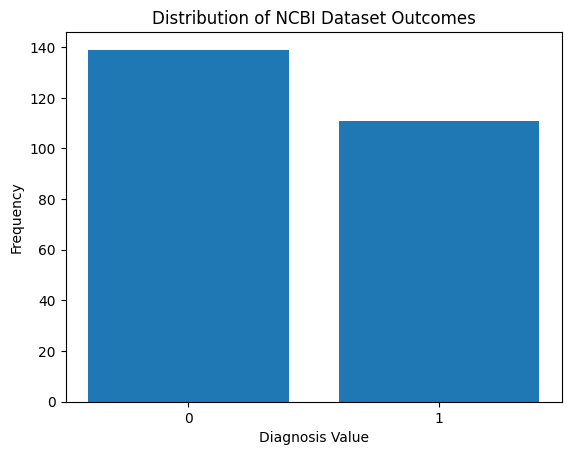

In [40]:
# Examine Distribution of ncbi dataset
ncbi_values = ncbiDataset['Diagnosis'].value_counts()
plt.bar(ncbi_values.index, ncbi_values.values)
plt.xticks([0,1])
plt.xlabel("Diagnosis Value")
plt.ylabel("Frequency")
plt.title("Distribution of NCBI Dataset Outcomes")
plt.show()

In [41]:
# Split data into training/validation and test (80/20)

train_ncbi_data, test_ncbi_data = train_test_split(ncbiDataset, test_size=0.2, random_state=4, shuffle=True)

print("train length is " + str(len(train_ncbi_data)) + "... test length is " + str(len(test_ncbi_data)))
print("train_urinary_data: \n", train_ncbi_data)
print("test_urinary_data: \n", test_ncbi_data)

train length is 200... test length is 50
train_urinary_data: 
        LYVE1      TFF1     REG1B  Creatinine  Diagnosis
27 -0.577293 -0.498533 -0.160845   -1.005056          0
16 -0.601634 -0.602931 -0.222204    1.325185          0
51 -0.575617 -0.315712 -0.233693   -0.976526          1
18  0.266584 -0.365430  0.443695   -1.022374          1
56 -0.577293 -0.856202 -0.160845   -0.164947          0
..       ...       ...       ...         ...        ...
57 -0.577293 -0.625448 -0.160845   -1.098712          0
26 -0.649492  0.894282 -0.211068    0.181930          1
12 -0.575617 -0.198974 -0.236383    0.794196          1
3  -0.677115 -0.231455 -0.035300   -0.620078          1
50 -0.032524  1.220588 -0.160845   -0.317312          0

[200 rows x 5 columns]
test_urinary_data: 
        LYVE1      TFF1     REG1B  Creatinine  Diagnosis
3   1.992331  1.282733 -0.222204   -1.322138          0
42  0.568486 -0.351525  0.377223    0.261343          1
9  -0.601634 -0.602931 -0.222204   -0.294469        

In [42]:
# NOTE: add/remove/adjust hyperparameters as you see fit
rf_ncbi = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_ncbi = XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.01)
svm_ncbi = SVC(C=1, kernel="rbf", random_state=42)
gnb_ncbi = GaussianNB()
knn_ncbi = KNeighborsClassifier()

In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

rf_ncbi_scores = []
xgb_ncbi_scores = []
svm_ncbi_scores = []
gnb_ncbi_scores = []
knn_ncbi_scores = []

X_ncbi = train_ncbi_data
kf = KFold(n_splits=10)

for train_index, val_index in kf.split(X_ncbi): #10 folds
    # set up training data
    train_chunk = X_ncbi.iloc[train_index]
    y_train = train_chunk['Diagnosis']
    X_train = train_chunk.drop(columns=['Diagnosis'])

    # set up validation data
    val_chunk = X_ncbi.iloc[val_index]
    y_val = val_chunk['Diagnosis']
    X_val = val_chunk.drop(columns=['Diagnosis'])

    # Random Forest
    rf_ncbi.fit(X_train, y_train)
    rf_pred = rf_ncbi.predict(X_val)
    rf_score = accuracy_score(y_val, rf_pred)
    rf_ncbi_scores.append(rf_score)

    # XGBoost
    xgb_ncbi.fit(X_train, y_train)
    xgb_pred = xgb_ncbi.predict(X_val)
    xgb_score = accuracy_score(y_val, xgb_pred)
    xgb_ncbi_scores.append(xgb_score)

    # SVM
    svm_ncbi.fit(X_train, y_train)
    svm_pred = svm_ncbi.predict(X_val)
    svm_score = accuracy_score(y_val, svm_pred)
    svm_ncbi_scores.append(svm_score)

    # Gaussian Naive Bayes
    gnb_ncbi.fit(X_train, y_train)
    gnb_pred = gnb_ncbi.predict(X_val)
    gnb_score = accuracy_score(y_val, gnb_pred)
    gnb_ncbi_scores.append(gnb_score)

    # KNearestNeighbors
    knn_ncbi.fit(X_train, y_train)
    knn_pred = knn_ncbi.predict(X_val)
    knn_score = accuracy_score(y_val, knn_pred)
    knn_ncbi_scores.append(knn_score)

print("RF training accuracies: ", rf_ncbi_scores)
print("RF mean: ", np.mean(rf_ncbi_scores))
print("RF standard dev: ", np.std(rf_ncbi_scores), "\n")

print("XGB training accuracies: ", xgb_ncbi_scores)
print("XGB mean: ", np.mean(xgb_ncbi_scores))
print("XGB standard dev: ", np.std(xgb_ncbi_scores), "\n")

print("SVM training accuracies: ", svm_ncbi_scores)
print("SVM mean: ", np.mean(svm_ncbi_scores))
print("SVM standard dev: ", np.std(svm_ncbi_scores), "\n")

print("GNB training accuracies: ", gnb_ncbi_scores)
print("GNB mean: ", np.mean(gnb_ncbi_scores))
print("GNB standard dev: ", np.std(gnb_ncbi_scores), "\n")

print("KNN training accuracies: ", knn_ncbi_scores)
print("KNN mean: ", np.mean(knn_ncbi_scores))
print("KNN standard dev: ", np.std(knn_ncbi_scores), "\n")

RF training accuracies:  [1.0, 0.95, 0.9, 0.95, 0.95, 1.0, 1.0, 0.85, 0.95, 0.95]
RF mean:  0.9499999999999998
RF standard dev:  0.0447213595499958 

XGB training accuracies:  [0.95, 0.9, 0.95, 0.9, 0.9, 1.0, 1.0, 0.8, 0.95, 0.95]
XGB mean:  0.9299999999999999
XGB standard dev:  0.055677643628300195 

SVM training accuracies:  [0.6, 0.75, 0.6, 0.45, 0.55, 0.5, 0.45, 0.35, 0.5, 0.55]
SVM mean:  0.53
SVM standard dev:  0.10295630140987 

GNB training accuracies:  [0.45, 0.4, 0.3, 0.5, 0.5, 0.5, 0.4, 0.55, 0.45, 0.6]
GNB mean:  0.465
GNB standard dev:  0.08077747210701756 

KNN training accuracies:  [0.9, 0.65, 0.6, 0.6, 0.65, 0.7, 0.65, 0.3, 0.7, 0.55]
KNN mean:  0.63
KNN standard dev:  0.14177446878757824 



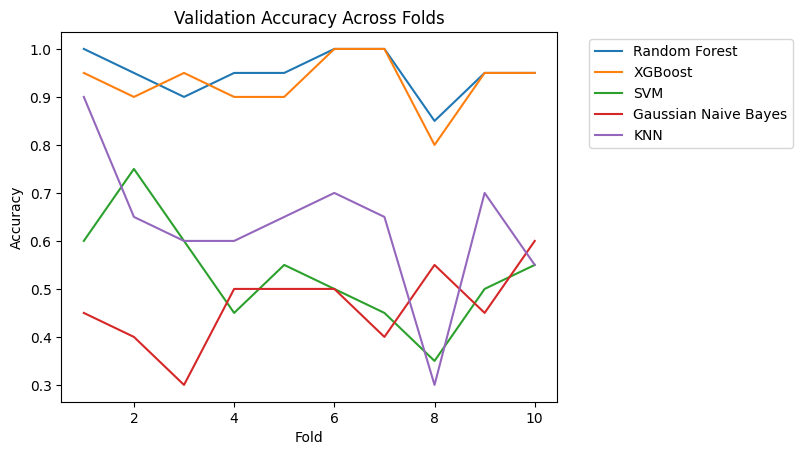

In [52]:
#Plot Validation Accuracy
foldsList = [i for i in range(1,11)]

plt.plot(foldsList, rf_ncbi_scores, label="Random Forest")
plt.plot(foldsList, xgb_ncbi_scores, label="XGBoost")
plt.plot(foldsList, svm_ncbi_scores, label="SVM")
plt.plot(foldsList, gnb_ncbi_scores, label="Gaussian Naive Bayes")
plt.plot(foldsList, knn_ncbi_scores, label="KNN")


plt.title("Validation Accuracy Across Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [45]:
# set up test data
X_ncbi_test = test_ncbi_data.drop(columns=['Diagnosis'])
y_ncbi_test = test_ncbi_data['Diagnosis']

# Random Forest
rf_ncbi_pred = rf_ncbi.predict(X_ncbi_test)
rf_ncbi_acc = accuracy_score(y_ncbi_test, rf_ncbi_pred)
print("RF test accuracy: ", rf_ncbi_acc)

# XGBoost
xgb_ncbi_pred = xgb_ncbi.predict(X_ncbi_test)
xgb_ncbi_acc = accuracy_score(y_ncbi_test, xgb_ncbi_pred)
print("XGB test accuracy: ", xgb_ncbi_acc)

# SVM
svm_ncbi_pred = svm_ncbi.predict(X_ncbi_test)
svm_ncbi_acc = accuracy_score(y_ncbi_test, svm_ncbi_pred)
print("SVM test accuracy: ", svm_ncbi_acc)

# Gaussian Naive Bayes
gnb_ncbi_pred = gnb_ncbi.predict(X_ncbi_test)
gnb_ncbi_acc = accuracy_score(y_ncbi_test, gnb_ncbi_pred)
print("GNB test accuracy: ", gnb_ncbi_acc)

# KNearestNeighbors
knn_ncbi_pred = knn_ncbi.predict(X_ncbi_test)
knn_ncbi_acc = accuracy_score(y_ncbi_test, knn_ncbi_pred)
print("KNN test accuracy: ", knn_ncbi_acc)

RF test accuracy:  0.96
XGB test accuracy:  0.92
SVM test accuracy:  0.52
GNB test accuracy:  0.5
KNN test accuracy:  0.6


In [46]:
# F1 scores for testing on NCBI dataset
rf_ncbi_f1 = f1_score(y_ncbi_test, rf_ncbi_pred)
xgb_ncbi_f1 = f1_score(y_ncbi_test, xgb_ncbi_pred)
svm_ncbi_f1 = f1_score(y_ncbi_test, svm_ncbi_pred)
gnb_ncbi_f1 = f1_score(y_ncbi_test, gnb_ncbi_pred)
knn_ncbi_f1 = f1_score(y_ncbi_test, knn_ncbi_pred)

print("RF F1 score: ", rf_ncbi_f1)
print("XGB F1 score: ", xgb_ncbi_f1)
print("SVM F1 score: ", svm_ncbi_f1)
print("GNB F1 score: ", gnb_ncbi_f1)
print("KNN F1 score: ", knn_ncbi_f1)

RF F1 score:  0.9583333333333334
XGB F1 score:  0.909090909090909
SVM F1 score:  0.29411764705882354
GNB F1 score:  0.358974358974359
KNN F1 score:  0.5238095238095238


# ----- SIGNIFICANCE ANALYSIS -----
# Significance Analysis of Results

- Do the McNemar test here for each of the models (10?) to compare

In [47]:
# ! pip3 install statsmodels

In [48]:
from statsmodels.stats.contingency_tables import mcnemar

'''
THOUGHTS: SHOULD WE DO IT BETWEEN THE BEST 2 MODELS IN EACH DATASET?
OR BEST AND WORST? I DON'T THINK WE SHOULD DO IT BETWEEN THE MODELS FOR 
DIFFERENT DATASETS, THAT'S NOT A FAIR COMPARISON

'''


#Idea is below:

#        Classifier2 Correct, Classifier2 Incorrect
#Classifier1 Correct:         ?? ??
#Classifier1 Incorrect:       ?? ??

#make a contingency table like below for 2 classifiers
#table = [[4, 2],
#		 [1, 3]]


#result = mcnemar(table, exact=True, correction=True)
#print(result.statistic)
#print(result.pvalue)
#reject null hypothesis if below 0.05?

"\nTHOUGHTS: SHOULD WE DO IT BETWEEN THE BEST 2 MODELS IN EACH DATASET?\nOR BEST AND WORST? I DON'T THINK WE SHOULD DO IT BETWEEN THE MODELS FOR \nDIFFERENT DATASETS, THAT'S NOT A FAIR COMPARISON\n\n"

# Comparison Across Datasets
- take urinary dataset models and try to predict on other dataset's test samples and vice versa
    - draw conclusions on the accuracy percentage and based on this, we can determine if the urinary biomarkers
        - are generalizeable to use on other data for predicting pancreatic cancer

In [53]:

print("URINARY MODELS ON NCBI DATASET")
# URINARY MODELS ON NCBI DATASET
X_ncbi_test = test_ncbi_data.drop(columns=['Diagnosis'])
y_ncbi_test = test_ncbi_data['Diagnosis']

# Random Forest
rf_pred = rf.predict(X_ncbi_test)
rf_acc = accuracy_score(y_ncbi_test, rf_pred)
print("RF test accuracy: ", rf_acc)

# XGBoost
xgb_pred = xgb.predict(X_ncbi_test)
xgb_acc = accuracy_score(y_ncbi_test, xgb_pred)
print("XGB test accuracy: ", xgb_acc)

# SVM
svm_pred = svm.predict(X_ncbi_test)
svm_acc = accuracy_score(y_ncbi_test, svm_pred)
print("SVM test accuracy: ", svm_acc)

# Gaussian Naive Bayes
gnb_pred = gnb.predict(X_ncbi_test)
gnb_acc = accuracy_score(y_ncbi_test, gnb_pred)
print("GNB test accuracy: ", gnb_acc)

# KNearestNeighbors
knn_pred = knn.predict(X_ncbi_test)
knn_acc = accuracy_score(y_ncbi_test, knn_pred)
print("KNN test accuracy: ", knn_acc)


URINARY MODELS ON NCBI DATASET
RF test accuracy:  0.48
XGB test accuracy:  0.46
SVM test accuracy:  0.5
GNB test accuracy:  0.46
KNN test accuracy:  0.54


In [54]:
rf_f1 = f1_score(y_ncbi_test, rf_pred)
xgb_f1 = f1_score(y_ncbi_test, xgb_pred)
svm_f1 = f1_score(y_ncbi_test, svm_pred)
gnb_f1 = f1_score(y_ncbi_test, gnb_pred)
knn_f1 = f1_score(y_ncbi_test, knn_pred)

print("\nF1 scores for urinary models on NCBI dataset")
print("RF F1 score: ", rf_f1)
print("XGB F1 score: ", xgb_f1)
print("SVM F1 score: ", svm_f1)
print("GNB F1 score: ", gnb_f1)
print("KNN F1 score: ", knn_f1)


F1 scores for urinary models on NCBI dataset
RF F1 score:  0.380952380952381
XGB F1 score:  0.22857142857142854
SVM F1 score:  0.4444444444444445
GNB F1 score:  0.27027027027027023
KNN F1 score:  0.46511627906976744


In [55]:
print("NCBI MODELS ON URINARY DATASET")
# NCBI MODELS ON URINARY DATASET
X_urinary_test = test_urinary_data.drop(columns=['Diagnosis'])
y_urinary_test = test_urinary_data['Diagnosis']

# Random Forest
rf_ncbi_pred = rf_ncbi.predict(X_urinary_test)
rf_ncbi_acc = accuracy_score(y_urinary_test, rf_ncbi_pred)
print("RF test accuracy: ", rf_ncbi_acc)

# XGBoost
xgb_ncbi_pred = xgb_ncbi.predict(X_urinary_test)
xgb_ncbi_acc = accuracy_score(y_urinary_test, xgb_ncbi_pred)
print("XGB test accuracy: ", xgb_ncbi_acc)

# SVM
svm_ncbi_pred = svm_ncbi.predict(X_urinary_test)
svm_ncbi_acc = accuracy_score(y_urinary_test, svm_ncbi_pred)
print("SVM test accuracy: ", svm_ncbi_acc)

# Gaussian Naive Bayes
gnb_ncbi_pred = gnb_ncbi.predict(X_urinary_test)
gnb_ncbi_acc = accuracy_score(y_urinary_test, gnb_ncbi_pred)
print("GNB test accuracy: ", gnb_ncbi_acc)

# KNearestNeighbors
knn_ncbi_pred = knn_ncbi.predict(X_urinary_test)
knn_ncbi_acc = accuracy_score(y_urinary_test, knn_ncbi_pred)
print("KNN test accuracy: ", knn_ncbi_acc)

NCBI MODELS ON URINARY DATASET
RF test accuracy:  0.3559322033898305
XGB test accuracy:  0.3728813559322034
SVM test accuracy:  0.6949152542372882
GNB test accuracy:  0.6949152542372882
KNN test accuracy:  0.559322033898305


In [ ]:
# Calculate F1 scores for NCBI models on urinary dataset
rf_ncbi_f1 = f1_score(y_urinary_test, rf_ncbi_pred)
xgb_ncbi_f1 = f1_score(y_urinary_test, xgb_ncbi_pred)
svm_ncbi_f1 = f1_score(y_urinary_test, svm_ncbi_pred)
gnb_ncbi_f1 = f1_score(y_urinary_test, gnb_ncbi_pred)
knn_ncbi_f1 = f1_score(y_urinary_test, knn_ncbi_pred)

print("\nF1 scores for NCBI models on urinary dataset")
print("RF F1 score: ", rf_ncbi_f1)
print("XGB F1 score: ", xgb_ncbi_f1)
print("SVM F1 score: ", svm_ncbi_f1)
print("GNB F1 score: ", gnb_ncbi_f1)
print("KNN F1 score: ", knn_ncbi_f1)